<a href="https://colab.research.google.com/github/ipanditi/Medical_Image_Processing/blob/main/nilearn_brain_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nibabel
Nibabel is a low-level Python library that gives access to a variety of imaging formats, with a particular focus on providing a common interface to the various volumetric formats produced by scanners and used in common neuroimaging toolkits.

* NIfTI-1
* NIfTI-2
* SPM Analyze
* FreeSurfer .mgh/.mgz files
* Philips PAR/REC
* Siemens ECAT
* DICOM (limited support)




In [6]:
pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
#Image settings
from nilearn import plotting
import pylab as plt
%matplotlib inline

import numpy as np
import nibabel as nb

In [23]:
img_func = nb.load('/content/sub-01_rest-EC.nii')

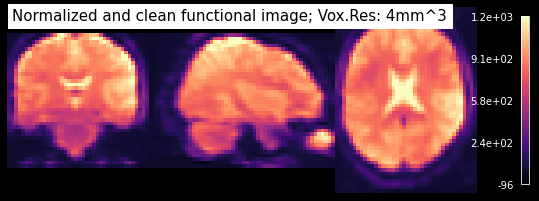

In [24]:
from nilearn.plotting import plot_anat
plot_anat(img_func.slicer[..., 0], dim='auto', draw_cross=False, annotate=False,
          cmap='magma', vmax=1250, cut_coords=[33,-20,20], colorbar=True,
          title='Normalized and clean functional image; Vox.Res: 4mm^3')

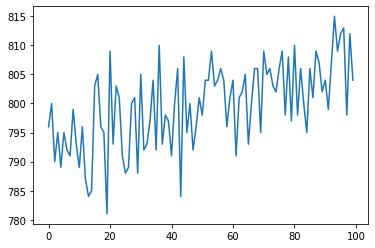

In [25]:
from matplotlib.pyplot import plot
plot(img_func.get_fdata()[19,16,17,:])

As we can see, the data still has a slight linear trend and is centered around a value of 800 (for this particular voxel). To be able to do some machine learning on this data we therefore need to remove the linear trend and ideally zscore the data.

This can be done with the following commands:

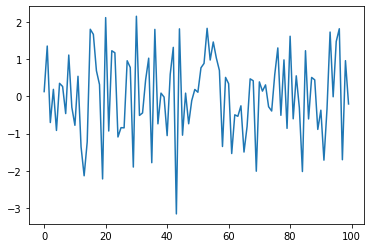

In [26]:
from scipy.signal import detrend
from scipy.stats import zscore

data = img_func.get_fdata()
data = detrend(data)
data = np.nan_to_num(zscore(data, axis=0))

#plot the cleaned data
plot(data[19,16,17,:])

Trend Successfully removed

2. How many nonzero voxels do we have?

In [27]:
img_func.get_fdata().shape

(40, 52, 38, 100)

In [28]:
np.sum(img_func.get_fdata().mean(axis=-1)!=0)

79040

Well, those are all voxels of the 40 x 52 x 38 matrix. It doesn't make sense that we run machine learning outside of the brain.

So let's use a mask to only keep those voxels that we're interested in. For this purpose we will use the MNI-152 template brain mask and an eye mask 

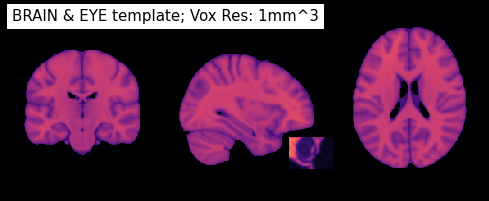

In [34]:
from nilearn.image import math_img

#Specify location of the brain and the eye image
brain = '/content/MNI152_T1_1mm_brain.nii'
eyes =  '/content/MNI152_T1_1mm_eye.nii'

#Combine the two template images
img_roi = math_img("img1 + img2", img1=brain, img2=eyes)

#Plot the region-of-interest (ROI) template
plot_anat(img_roi, dim='auto', draw_cross=False, annotate=False, cmap='magma',
          cut_coords=[33, -20, 20], title='BRAIN & EYE template; Vox Res: 1mm^3')

Great, now we just need to binarize this template to get a mask, dilate this mask a bit to be sure that we keep all relevant voxels and multiply it with the functional image. But before we can do any of this we also need to resample the ROI template to a voxel resolution for 4x4x4mm, as the functional images.

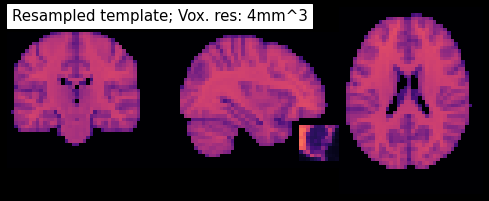

In [35]:
from nilearn.image import resample_to_img
#Make img_roi same size as img_func i.e, 4mm^3
img_resampled = resample_to_img(img_roi, img_func)

#Plot
plot_anat(img_resampled, dim='auto', draw_cross=False, annotate=False, cmap='magma',
          cut_coords=[33,-20,20], title='Resampled template; Vox. res: 4mm^3')

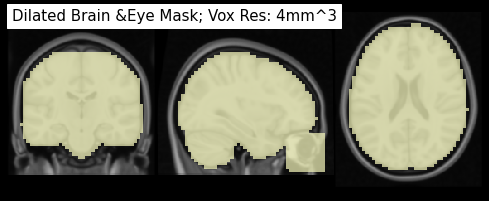

In [37]:
from scipy.ndimage import binary_dilation

#Binarize ROI template
data_binary = np.array(img_resampled.get_fdata()>=10, dtype=np.int8)

#Dilate binary mask
data_dilated  = binary_dilation(data_binary, iterations=1).astype(np.int8)

#save binary mask in NIfTI image
img_mask = nb.Nifti1Image(data_dilated, img_resampled.affine, img_resampled.header)
img_mask.set_data_dtype('i1')

#Plot
from nilearn.plotting import plot_roi
plot_roi(img_mask, draw_cross=False, annotate=False,
         bg_img = '/content/MNI152_T1_1mm.nii', cut_coords=[33,-20,20],
         title='Dilated Brain &Eye Mask; Vox Res: 4mm^3', cmap='magma_r', dim=1)

In [38]:
np.sum(img_mask.get_fdata())

36575.0

Initially we had 79040 number of voxels, now it has reduced to 36575, which is about 53% reduction.
Now we only have to miltiply this mask with our fucntional images and remove tailing zeros from the 3D matrix. 
Initial Image (For reference):

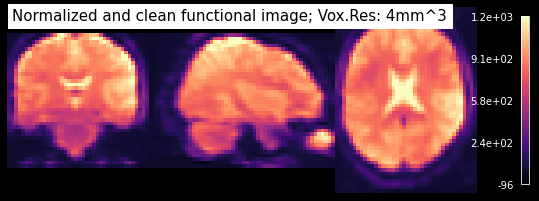

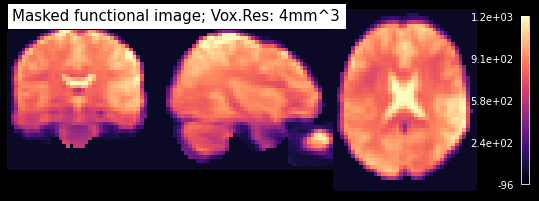

In [40]:
#Multiply the functional image with mask
img_cleaned = math_img('img1 * img2', img1 = img_func, img2 = img_mask.slicer[..., None])

#Remove as many zero rows in the data matrix to reduce the overall volume size
from nilearn.image import crop_img
img_crop = crop_img(img_cleaned)

#Plot
plot_anat(img_crop.slicer[..., 0], dim='auto', draw_cross=False, annotate=False,
          cmap='magma', vmax=1250, cut_coords=[33,-20,20], colorbar=True,
          title='Masked functional image; Vox.Res: 4mm^3')

Creating the Dataset for ML : 

We want to predict if a person has their eyes closed or open during a resting state scan. Our assumption is that during the eyes open there is more eye movement, more visual stimulation, i.e. more variance in certain regions. Therefore, we want to look at the standard deviation over time (i.e. over the 100 volumes per run).

In [41]:
img_std1 = nb.Nifti1Image(img_crop.get_fdata()[...,0:25].std(axis=-1), img_crop.affine, img_crop.header)
img_std2 = nb.Nifti1Image(img_crop.get_fdata()[...,25:50].std(axis=-1), img_crop.affine, img_crop.header)
img_std3 = nb.Nifti1Image(img_crop.get_fdata()[...,50:75].std(axis=-1), img_crop.affine, img_crop.header)
img_std4 = nb.Nifti1Image(img_crop.get_fdata()[...,75:100].std(axis=-1), img_crop.affine, img_crop.header)

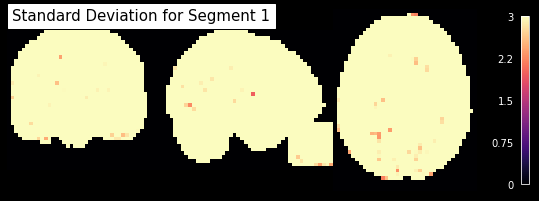

In [42]:
plot_anat(img_std1, draw_cross=False, annotate=False, cmap='magma',
          cut_coords=[33, -20, 20], vmax=3, colorbar=True,
          title='Standard Deviation for Segment 1')

# Machine Learning 

In [60]:
func = nb.load('/content/dataset_ML.nii')

In [61]:
# For quicker access, let's also create a functional mean image
img_mean = mean_img(func)
img_mean.shape

(40, 51, 41)

In [62]:
def create_mask(img_roi, img_mean):

  #Resample mask to functional space
  img_resampled = resample_to_img(img_roi, img_mean)

  #Binarize ROI template
  data_binary = np.arry(img_resampled.get_fdata()!=0, dtype=np.int8)

  #Dilate binary mask
  data_dialated  = binary_dilation(data_binary, iterations=1).astype(np.int8)

  #Save binary mask in NIfTI image
  mask = nb.Nifti1Image(data_dilated, img_resampled.affine, img_resampled.header)
    
  # Restrict mask only to voxels with functional values
  mask = math_img("(mean * mask)>0", mean=img_mean, mask=mask)
  mask.set_data_dtype('i1')
    
  return mask

Let's create some masks

/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


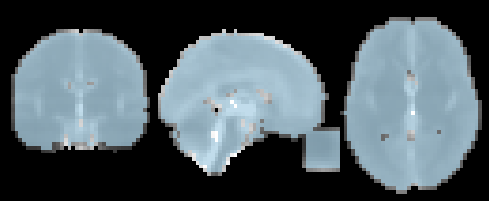

In [63]:
img_roi = math_img("(img1 + img2)>0", img1=brain, img2=eyes)
img_resampled = resample_to_img(img_roi, img_mean)
mask_global = math_img("((mean!=0)*img)>0.5", mean=img_mean, img=img_resampled)

# Plotting global mask
anat = '/content/MNI152_T1_1mm.nii'
plot_roi(mask_global, img_mean, cmap='Paired', dim=-.5, draw_cross=False, annotate=False)

/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


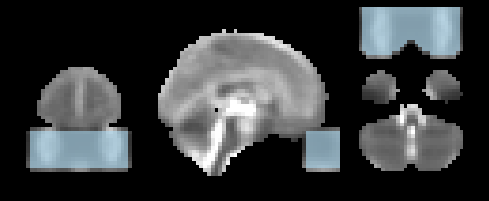

In [64]:
# Create eye mask containing both eyes
img_roi = math_img("img>0", img=eyes)
img_resampled = resample_to_img(img_roi, img_mean)
mask_eye = math_img("((mean!=0)*img)>0.5", mean=img_mean, img=img_resampled)

# Plotting global mask
anat = '/content/MNI152_T1_1mm.nii'
plot_roi(mask_eye, img_mean, cmap='Paired', dim=-.5, draw_cross=False, annotate=False);

In [65]:
# Load labels from AtlasReader
atlas_labels = pd.read_excel('Book1.xlsx', index_col=0)
atlas_labels.head()

,name
index,
0,Left_Frontal_Pole
1,Right_Frontal_Pole
2,Left_Insular_Cortex
3,Right_Insular_Cortex
4,Left_Superior_Frontal_Gyrus


In [122]:
# Load atlas from AtlasReader
img_atlas = nb.load( '/content/atlas_harvard_oxford.nii')
img_atlas.shape

(151, 194, 159, 113)

In [124]:
# Load V1 ROI labels
idx_v1 = [92, 93, 94, 95]
display(atlas_labels.iloc[idx_v1])

,name
index,
92,Left_Supracalcarine_Cortex
93,Right_Supracalcarine_Cortex
94,Left_Occipital_Pole
95,Right_Occipital_Pole


/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


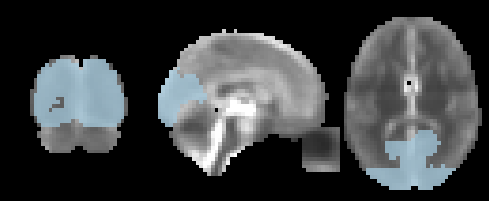

In [125]:
# Create V1 mask
roi_v1 = mean_img([img_atlas.slicer[..., v] for v in idx_v1])
img_roi = math_img("img>0", img=roi_v1)
img_resampled = resample_to_img(img_roi, img_mean)
mask_v1 = math_img("((mean!=0)*img)>0.5", mean=img_mean, img=img_resampled)

# Plotting V1 mask
plot_roi(mask_v1, img_mean, cmap='Paired', dim=-.5, draw_cross=False, annotate=False);

In [126]:
# Load A1 ROI labels
idx_a1 = [88, 89, 90, 91]
display(atlas_labels.iloc[idx_a1])

,name
index,
88,Left_Heschl's_Gyrus_(includes_H1_and_H2)
89,Right_Heschl's_Gyrus_(includes_H1_and_H2)
90,Left_Planum_Temporale
91,Right_Planum_Temporale


/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int8 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/lib/python3.7/dist-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


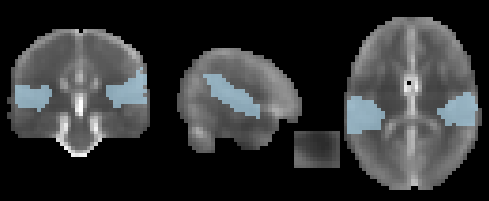

In [127]:
# Create A1 mask
roi_a1 = mean_img([img_atlas.slicer[..., a] for a in idx_a1])
img_roi = math_img("img>0", img=roi_a1)
img_resampled = resample_to_img(img_roi, img_mean)
mask_a1 = math_img("((mean!=0)*img)>0.5", mean=img_mean, img=img_resampled)

# Plotting V1 mask
plot_roi(mask_a1, img_mean, cmap='Paired', dim=-.5, draw_cross=False, annotate=False);

In [128]:
labels = np.ravel([[['closed'] * 4, ['open'] * 4] for i in range(48)])
labels[:20]

array(['closed', 'closed', 'closed', 'closed', 'open', 'open', 'open',
       'open', 'closed', 'closed', 'closed', 'closed', 'open', 'open',
       'open', 'open', 'closed', 'closed', 'closed', 'closed'],
      dtype='<U6')

In [129]:
chunks = np.ravel([[i] * 64 for i in range(6)])
chunks[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [130]:
mask2use = mask_v1

In [131]:
# Mask ML dataset with V1 ROI mask
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask2use, standardize=False, detrend=False,
                     memory="nilearn_cache", memory_level=2)
samples = masker.fit_transform(func)
print(samples)

/usr/local/lib/python3.7/dist-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


[[0.7897581  0.8949832  1.065642   ... 0.8487248  1.406102   1.6080661 ]
 [0.6634731  0.7264083  0.8240822  ... 1.206304   1.0572822  1.7161686 ]
 [0.5277856  0.87295365 1.3207896  ... 1.852575   1.2465636  1.7527636 ]
 ...
 [0.73879707 0.9643014  1.0316637  ... 1.0771223  0.60332584 1.0882887 ]
 [0.97698224 0.8522596  0.89267045 ... 0.71301985 0.8910863  1.051655  ]
 [0.70037246 0.8901158  0.91494864 ... 0.94807017 0.99307054 1.1872233 ]]


In [132]:
print(samples.shape)
masked_epi = masker.inverse_transform(samples)

(384, 2237)


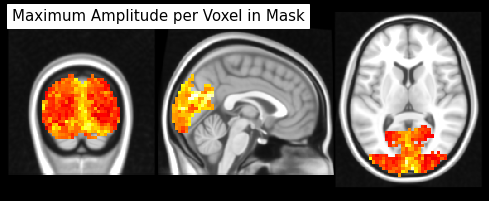

In [133]:
from nilearn.plotting import plot_stat_map

max_zscores = math_img("np.abs(img).max(axis=3)", img=masked_epi)
plot_stat_map(max_zscores, bg_img=anat, dim=-.5,
              draw_cross=False, annotate=False, colorbar=False,
              title='Maximum Amplitude per Voxel in Mask')

In [134]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train_v1, X_test_v1, y_train_v1, y_test_v1, c_train, c_test = train_test_split(
    samples, labels=='open', chunks, test_size=64, random_state=0, shuffle=False)

print('Shapes of X:', X_train_v1.shape, X_test_v1.shape)
print('Shapes of y:', y_train_v1.shape, y_test_v1.shape)

Shapes of X: (320, 2237) (64, 2237)
Shapes of y: (320,) (64,)


In [135]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [136]:
# Create pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LinearSVC(multi_class='ovr', penalty='l2',
                      loss='squared_hinge', max_iter=500))
])
# Create parameter grid to be explored during grid search
grid = {
    'svc__C': np.logspace(-6, 2, num=40),
}

# Create grid search object with a cross-validation with LeaveOneGroupOut
from sklearn.model_selection import LeaveOneGroupOut
grid_cv_v1 = GridSearchCV(pipe, grid, cv=LeaveOneGroupOut(),
                          return_train_score=True, refit=True, n_jobs=-1, verbose=1)

# Train the model and find optimal hyperparameter
grid_cv_v1.fit(X=X_train_v1, y=y_train_v1, groups=c_train);


Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [137]:
def plot_hyperparam_fitting(cv_results):

    # Store grid search parameters and outcomes in dataframe
    df_pred = pd.DataFrame(cv_results)
    columns = [c for c in df_pred.columns if 'time' not in c
               and 'split' not in c
               and 'rank' not in c
               and c!='params']
    df_pred = df_pred[columns].sort_values('mean_test_score', ascending=False)
    display(df_pred.head())
    
    # Plot the model fit information
    df_plot = df_pred.sort_values('param_svc__C')

    # Exsract relevant modelling metrics
    train_scores = df_plot['mean_train_score']
    valid_scores = df_plot['mean_test_score']
    std_tr = df_plot['std_train_score']
    std_va = df_plot['std_test_score']

    plt.figure(figsize=(12, 4))
    Cs = df_plot['param_svc__C']
    plt.semilogx(Cs, train_scores, label='Training Set')
    plt.semilogx(Cs, valid_scores, label='Validation Set')

    # Add marker and text for best score
    max_id = np.argmax(valid_scores)
    x_pos = Cs.iloc[max_id]
    y_pos = valid_scores.iloc[max_id]
    txt = '{:0.4f}'.format(y_pos)
    plt.scatter(x_pos, y_pos, marker='x', c='red', zorder=10)
    plt.text(x_pos, y_pos, txt, fontdict={'size': 18})

    # Quantify variance with ±std curves
    plt.fill_between(Cs.astype(float), train_scores-std_tr, train_scores+std_tr, alpha=0.3)
    plt.fill_between(Cs.astype(float), valid_scores-std_va, valid_scores+std_va, alpha=0.3)
    plt.ylabel('Performance metric')
    plt.xlabel('Model parameter')

    # Adjust x-lim, y-lim, add legend and adjust layout
    plt.legend()
    plt.show()

,param_svc__C,mean_test_score,std_test_score,mean_train_score,std_train_score
10,0.000113,0.756250,0.042619,0.962500,0.008043
7,0.000027,0.753125,0.053583,0.907813,0.010655
8,0.000044,0.753125,0.051728,0.928125,0.007245
6,0.000017,0.750000,0.046351,0.878125,0.016646
9,0.00007,0.746875,0.049804,0.945312,0.007412


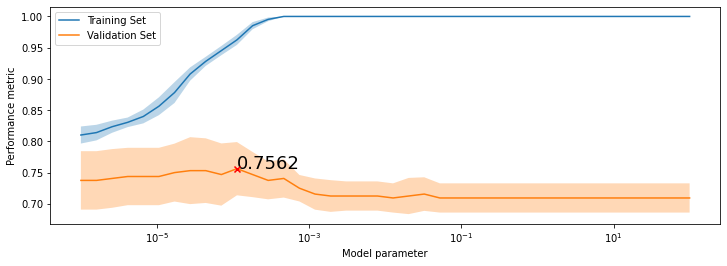

In [138]:
# Plot hyperparameter fine tuning outcome
plot_hyperparam_fitting(grid_cv_v1.cv_results_)

In [139]:
# Mask ML dataset with A1 ROI mask
mask2use = mask_a1
masker = NiftiMasker(mask_img=mask2use, standardize=False, detrend=False,
                     memory="nilearn_cache", memory_level=2)
samples = masker.fit_transform(func)

/usr/local/lib/python3.7/dist-packages/nilearn/maskers/base_masker.py:96: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


In [140]:
# Split the data into training and test sets
X_train_a1, X_test_a1, y_train_a1, y_test_a1, c_train, c_test = train_test_split(
    samples, labels=='open', chunks, test_size=64, random_state=0, shuffle=False)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


,param_svc__C,mean_test_score,std_test_score,mean_train_score,std_train_score
39,100.0,0.534375,0.048814,1.000000,0.000000
15,0.001194,0.534375,0.043526,0.999219,0.001563
38,62.355073,0.534375,0.048814,1.000000,0.000000
37,38.881552,0.534375,0.048814,1.000000,0.000000
36,24.24462,0.534375,0.048814,1.000000,0.000000


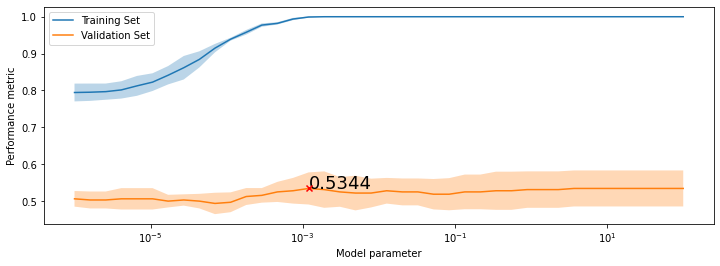

Test score based on A1: 0.453125


In [141]:
# Create grid search object with a cross-validation with LeaveOneGroupOut
grid_cv_a1 = GridSearchCV(pipe, grid, cv=LeaveOneGroupOut(),
                          return_train_score=True, refit=True, n_jobs=-1, verbose=1)
# Train the model and find optimal hyperparameter
grid_cv_a1.fit(X=X_train_a1, y=y_train_a1, groups=c_train);

# Plot hyperparameter fine tuning outcome
plot_hyperparam_fitting(grid_cv_a1.cv_results_)

score_test_a1 = grid_cv_a1.score(X_test_a1, y_test_a1)
print('Test score based on A1:', score_test_a1)

In [142]:
# Mask ML dataset with eye ROI mask
mask2use = mask_eye
masker = NiftiMasker(mask_img=mask2use, standardize=False, detrend=False,
                     memory="nilearn_cache", memory_level=2)
samples = masker.fit_transform(func)

/usr/local/lib/python3.7/dist-packages/nilearn/maskers/base_masker.py:96: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


,param_svc__C,mean_test_score,std_test_score,mean_train_score,std_train_score
17,0.00307,0.815625,0.040020,1.0,0.0
15,0.001194,0.815625,0.036174,1.0,0.0
14,0.000744,0.815625,0.036174,1.0,0.0
16,0.001914,0.812500,0.035630,1.0,0.0
18,0.004924,0.806250,0.033657,1.0,0.0


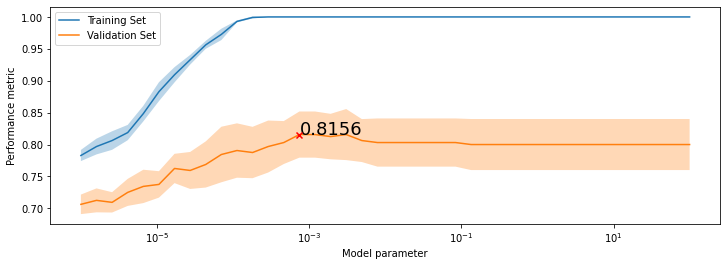

Test score based on A1: 0.921875


In [143]:
# Split the data into training and test sets
X_train_eye, X_test_eye, y_train_eye, y_test_eye, c_train, c_test = train_test_split(
    samples, labels=='open', chunks, test_size=64, random_state=0, shuffle=False)

# Create grid search object with a cross-validation with LeaveOneGroupOut
grid_cv_eye = GridSearchCV(pipe, grid, cv=LeaveOneGroupOut(),
                           return_train_score=True, refit=True, n_jobs=-1, verbose=1)

# Train the model and find optimal hyperparameter
grid_cv_eye.fit(X=X_train_eye, y=y_train_eye, groups=c_train);

# Plot hyperparameter fine tuning outcome
plot_hyperparam_fitting(grid_cv_eye.cv_results_)

score_test_eye = grid_cv_eye.score(X_test_eye, y_test_eye)
print('Test score based on A1:', score_test_eye)

# **Deep Learning Approach**

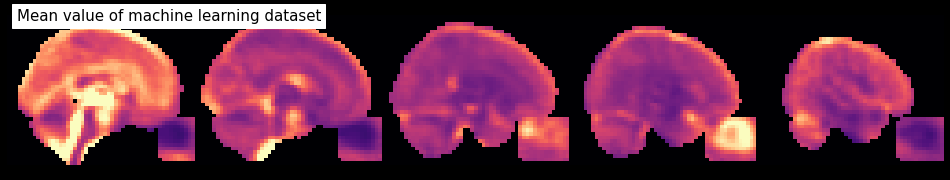

In [123]:
from nilearn.image import mean_img
plot_anat(mean_img(func), cmap='magma', colorbar=False, display_mode='x', vmax=2, annotate=False,
          cut_coords=range(0, 49, 12), title='Mean value of machine learning dataset');

In [76]:
labels = np.ravel([[['closed'] * 4, ['open'] * 4] for i in range(48)])
labels[:20]

array(['closed', 'closed', 'closed', 'closed', 'open', 'open', 'open',
       'open', 'closed', 'closed', 'closed', 'closed', 'open', 'open',
       'open', 'open', 'closed', 'closed', 'closed', 'closed'],
      dtype='<U6')

In [77]:
#Second, the chunks variable should not switch between subjects. So, as before, we can again specify 6 chunks of 64 volumes (8 subjects), each:
chunks = np.ravel(([i] * 64 for i in range(6)))
chunks[:150]

array([<generator object <genexpr> at 0x7fdb20990750>], dtype=object)

# Keras
Convoluted neural networks are very powerful (as you will see), but the computation power to train the models can be incredibly demanding. For this reason, it's sometimes recommended to try to reduce the input space if possible.

In our case, we could try to not train the neural network only on one very thin slab (a few slices) of the brain. So, instead of taking the data matrix of the whole brain, we just take 2 slices in the region that we think is most likely to be predictive for the question at hand.

We know (or suspect) that the regions with the most predictive power are probably somewhere around the eyes and in the visual cortex. So let's try to specify a few slices that cover those regions.

So, let's try to just take a few slices around the eyes:

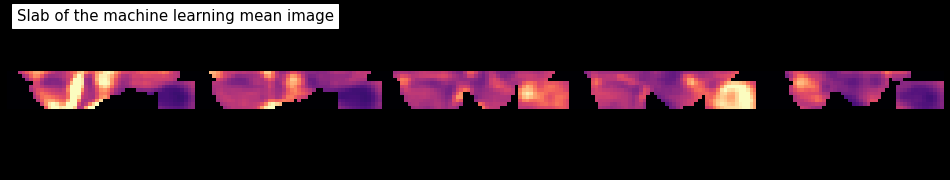

In [78]:
plot_anat(mean_img(func).slicer[...,5:-25], cmap='magma', colorbar=False,
          display_mode = 'x', vmax = 2, annotate=False, cut_coords = range(0,49, 12),
          title= 'Slab of the machine learning mean image');

Hmm.. that doesn't seem to work. We want to cover the eyes and the visual cortex. Like this, we're too far down in the back of the head (at the Cerebellum). One solution to this is to rotate the volume.

So let's do that:

In [79]:
#Rotation parameters 
phi = 0.35
cos = np.cos(phi)
sin = np.sin(phi)

#Compute rotation matrix around x-axis
rotation_affine = np.array([[1,0,0,0],
                           [0,cos, -sin, 0],
                           [0, sin, cos, 0],
                           [0,0,0,1]])
new_affine = rotation_affine.dot(func.affine)

In [80]:
#Rotate and resample image to new orientation
from nilearn.image import resample_img
new_img = nb.Nifti1Image(func.get_data(), new_affine)
img_rot = resample_img(new_img, func.affine, interpolation = 'continuous')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
#Delete zero-only rows and columns 
img_crop = crop_img(img_rot)

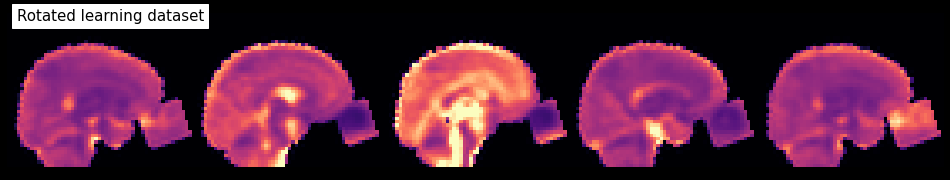

In [82]:
#Check by plotting
plot_anat(mean_img(img_crop), cmap='magma', colorbar=False,
          display_mode = 'x', vmax=2, annotate=False, cut_coords=range(-20, 30, 12),
          title = 'Rotated learning dataset')

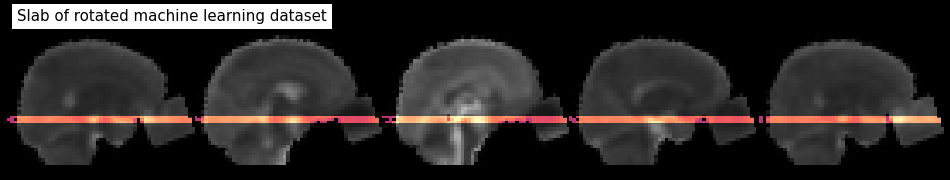

In [84]:
from nilearn.plotting import plot_stat_map
img_slab = img_crop.slicer[..., 12:15, :]
plot_stat_map(mean_img(img_slab), cmap='magma', bg_img=mean_img(img_crop), colorbar=False,
              display_mode='x', vmax=2, annotate=False, cut_coords=range(-20, 30, 12),
              title='Slab of rotated machine learning dataset');

In [85]:
#Split into train and test
data = np.rollaxis(img_slab.get_fdata(), 3,0)
data.shape

(384, 40, 56, 3)

As you can see, the goal is to have in the first dimension, the different volumes, and then the volume itself. Keep in mind, that the last dimension (here of size 2), are considered as channels in the keras model that we will be using below.

In [86]:
y = labels == 'open'
y.shape

(384,)

In [87]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=0, shuffle=False)
print('Shapes of X:', X_train.shape, X_test.shape)
print('Shapes of Y:', y_train.shape, y_test.shape)

Shapes of X: (307, 40, 56, 3) (77, 40, 56, 3)
Shapes of Y: (307,) (77,)


In [90]:
#Model creation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD

In [89]:
#Get shapes
data_shape = tuple(X_train.shape[1:])

#Specify shape of convolution matrix
kernel_size = (3,3)

#Specify number of output categories
n_classes = 2

In [94]:
filters =32
model = tf.keras.models.Sequential([
    #First convolution
    tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', input_shape= data_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    #Second convolution
    tf.keras.layers.Conv2D(filters*2, kernel_size, activation='relu', input_shape= data_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    #Third convolution
    tf.keras.layers.Conv2D(filters*4, kernel_size, activation='relu', input_shape= data_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),

    #Dense network 1
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Dense Network 2
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Dense Network 2
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #Final dropout and classification 
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [95]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 38, 54, 32)        896       
                                                                 
 batch_normalization_18 (Bat  (None, 38, 54, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 19, 27, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 25, 64)        18496     
                                                                 
 batch_normalization_19 (Bat  (None, 17, 25, 64)       256       
 chNormalization)                                                
                                                      

In [96]:
#Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'adam', #Try sgd too
              metrics = ['accuracy'])

In [97]:
%time fit = model.fit(X_train, y_train, epochs = 125, batch_size= 32, validation_split=0.2)

Epoch 1/125
8/8 [==============================] - 5s 262ms/step - loss: 1.5295 - accuracy: 0.4857 - val_loss: 0.6781 - val_accuracy: 0.6935
Epoch 2/125
8/8 [==============================] - 2s 213ms/step - loss: 1.3178 - accuracy: 0.5837 - val_loss: 0.6783 - val_accuracy: 0.5968
Epoch 3/125
8/8 [==============================] - 2s 203ms/step - loss: 1.3394 - accuracy: 0.6041 - val_loss: 0.6727 - val_accuracy: 0.5968
Epoch 4/125
8/8 [==============================] - 2s 205ms/step - loss: 1.3274 - accuracy: 0.6694 - val_loss: 0.7198 - val_accuracy: 0.5000
Epoch 5/125
8/8 [==============================] - 2s 204ms/step - loss: 0.8831 - accuracy: 0.7306 - val_loss: 0.6508 - val_accuracy: 0.5323
Epoch 6/125
8/8 [==============================] - 2s 204ms/step - loss: 0.9884 - accuracy: 0.7184 - val_loss: 0.6375 - val_accuracy: 0.6290
Epoch 7/125
8/8 [==============================] - 2s 207ms/step - loss: 0.6739 - accuracy: 0.7878 - val_loss: 0.6474 - val_accuracy: 0.5323
Epoch 8/125
8

Performance during model fitting

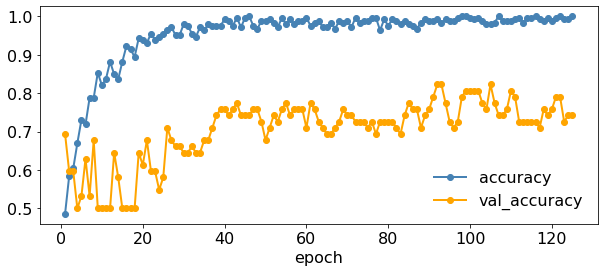

In [98]:
fig = plt.figure(figsize=(10,4))
epoch = np.arange(125) + 1
fontsize = 16
plt.plot(epoch, fit.history['accuracy'], marker="o", linewidth=2,
         color="steelblue", label="accuracy")
plt.plot(epoch, fit.history['val_accuracy'], marker="o", linewidth=2,
         color="orange", label="val_accuracy")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

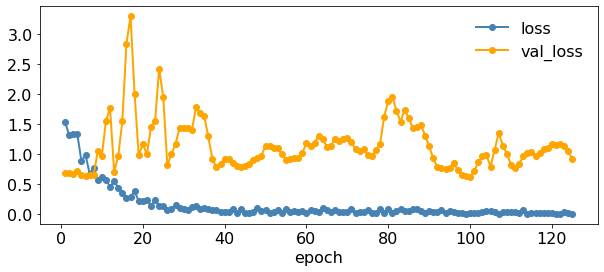

In [99]:
fig = plt.figure(figsize=(10, 4))
epoch = np.arange(125) + 1
fontsize = 16
plt.plot(epoch, fit.history['loss'], marker="o", linewidth=2,
         color="steelblue", label="loss")
plt.plot(epoch, fit.history['val_loss'], marker="o", linewidth=2,
         color="orange", label="val_loss")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

# Evaluating the model

In [100]:
evaluation = model.evaluate(X_test, y_test)
print('Loss in Test set:      %.02f' % (evaluation[0]))
print('Accuracy in Test set:  %.02f' % (evaluation[1] * 100))

3/3 [==============================] - 0s 36ms/step - loss: 0.4227 - accuracy: 0.8961
Loss in Test set:      0.42
Accuracy in Test set:  89.61


# **Confusion Matrix**

In [101]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [102]:
y_true = y_test * 1
y_true

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1])

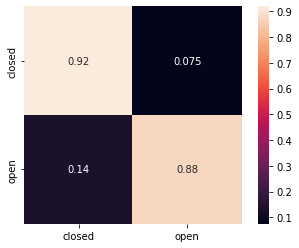

In [104]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
class_labels = ['closed', 'open']
cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index=class_labels, columns=class_labels)
sns.heatmap(cm/cm.sum(axis=1), square=True, annot=True);

Analyzing prediction values

In [105]:
y_pred = model.predict(X_test)
y_pred[:10,:]

array([[9.9999988e-01, 1.5276099e-07],
       [9.0177166e-01, 9.8228350e-02],
       [5.0345495e-02, 9.4965452e-01],
       [6.7091553e-04, 9.9932909e-01],
       [2.2717373e-04, 9.9977285e-01],
       [9.9832863e-01, 1.6713404e-03],
       [9.9053127e-01, 9.4687296e-03],
       [8.6005127e-01, 1.3994871e-01],
       [7.0030279e-02, 9.2996973e-01],
       [1.6700454e-06, 9.9999833e-01]], dtype=float32)

As you can see, those values can be between 0 and 1.

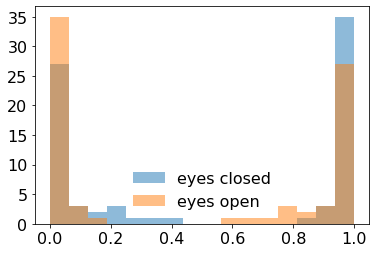

In [106]:
fig = plt.figure(figsize=(6, 4))
fontsize = 16
plt.hist(y_pred[:,0], bins=16, label='eyes closed', alpha=0.5)
plt.hist(y_pred[:,1], bins=16, label='eyes open', alpha=0.5);
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

The more both distributions are distributed around chance level, the weaker your model is.

Note: Keep in mind that we trained the whole model only on one split of test and training data. Ideally, you would repeat this process many times so that your results become less dependent on what kind of split you did.

Visualizing the training of model

In [109]:
from tensorflow.keras import backend as K

# Aggregate the layers
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Specify a function that visualized the layers
def show_activation(layer_name):
    
    layer_output = layer_dict[layer_name].output

    fn = K.function([model.input], [layer_output])
    
    inp = X_train[0:1]
    
    this_hidden = fn([inp])[0]
    
    # plot the activations, 8 filters per row
    plt.figure(figsize=(16,8))
    nFilters = this_hidden.shape[-1]
    nColumn = 8 if nFilters >= 8 else nFilters
    for i in range(nFilters):
        plt.subplot(nFilters / nColumn, nColumn, i+1)
        plt.imshow(this_hidden[0,:,:,i], cmap='magma', interpolation='nearest')
        plt.axis('off')
    
    return 

In [116]:
model.layers[0].name

'conv2d_9'

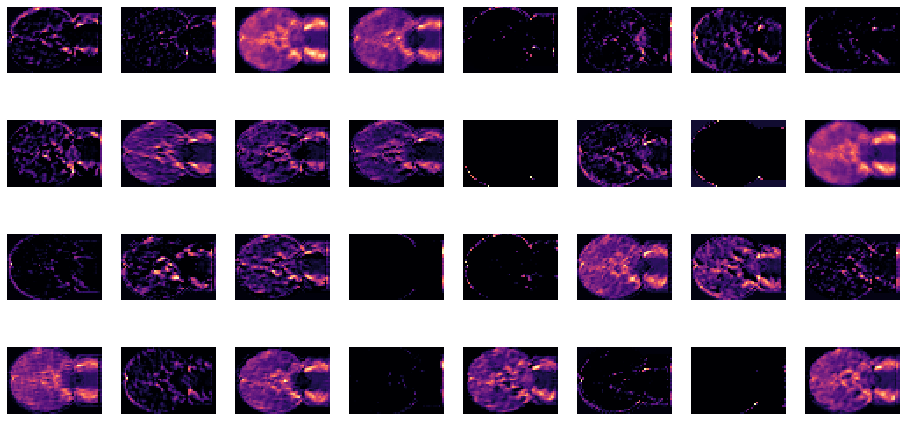

In [117]:
show_activation('conv2d_9')

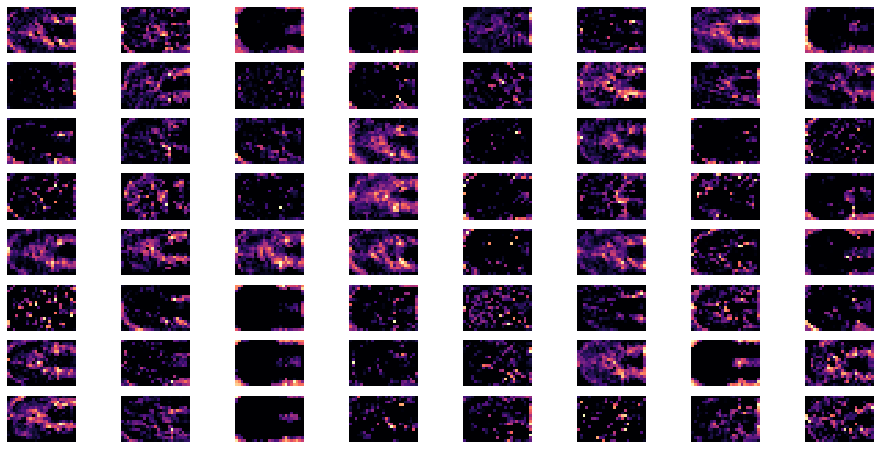

In [118]:
show_activation('conv2d_10')

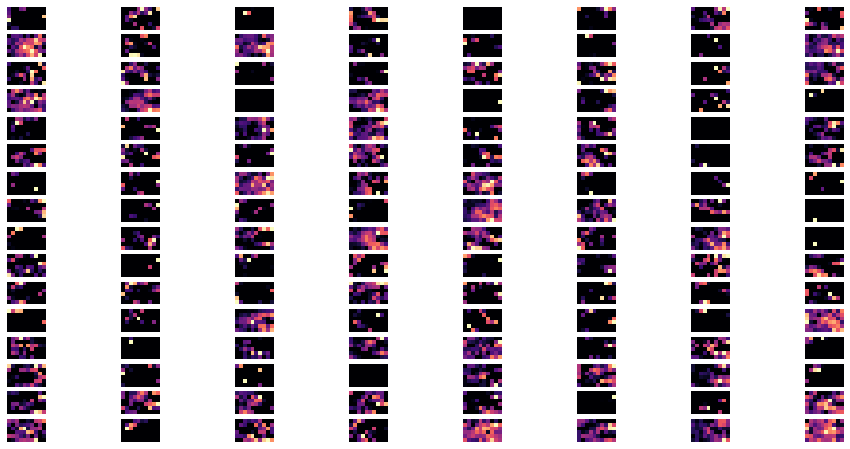

In [119]:
show_activation('conv2d_11')